# Pythia developmental anlaysis

Goal: Tracking emergence of sense knowledge in Pythia suite across time.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

import functools
import itertools
import os
import torch
import transformers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.spatial.distance import cosine
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
import statsmodels.formula.api as smf


sns.set(style='whitegrid',font_scale=1.2)

In [2]:
from transformers import GPTNeoXForCausalLM, AutoTokenizer

## Custom fucnctions

In [3]:
### Define useful custom functions to ...

### ... find the target tokens within tokenized sequence
def find_sublist_index(mylist, sublist):
    """Find the first occurence of sublist in list.
    Return the start and end indices of sublist in list"""

    for i in range(len(mylist)):
        if mylist[i] == sublist[0] and mylist[i:i+len(sublist)] == sublist:
            return i, i+len(sublist)
    return None

@functools.lru_cache(maxsize=None)  # This will cache results, handy later...


### ... grab the embeddings for your target tokens
def get_embedding(model, tokenizer, sentence, target, layer, device):
    """Get a token embedding for target in sentence"""
    
    # Tokenize sentence
    inputs = tokenizer(sentence, return_tensors="pt").to(device)
    
    # Tokenize target
    target_enc = tokenizer.encode(target, return_tensors="pt",
                                  add_special_tokens=False).to(device)
    
    # Get indices of target in input tokens
    target_inds = find_sublist_index(
        inputs["input_ids"][0].tolist(),
        target_enc[0].tolist()
    )

    # Run model
    with torch.no_grad():
        output = model(**inputs)
        hidden_states = output.hidden_states

    # Get layer
    selected_layer = hidden_states[layer][0]

    #grab just the embeddings for your target word's token(s)
    token_embeddings = selected_layer[target_inds[0]:target_inds[1]]

    #if a word is represented by >1 tokens, take mean
    #across the multiple tokens' embeddings
    embedding = torch.mean(token_embeddings, dim=0)
    
    return embedding

### ... grab the number of trainable parameters in the model

def count_parameters(model):
    """credit: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model"""
    
    total_params = 0
    for name, parameter in model.named_parameters():
        
        # if the param is not trainable, skip it
        if not parameter.requires_grad:
            continue
        
        # otherwise, count it towards your number of params
        params = parameter.numel()
        total_params += params
    print(f"Total Trainable Params: {total_params}")
    
    return total_params
    

In [4]:
def generate_revisions():
    # Fixed initial steps
    revisions = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1000]
    # Add every 1,000 steps afterward
    revisions.extend(range(2000, 144000, 1000))  # Adjust range as needed
    # Format each step as "stepX"
    return [f"step{step}" for step in revisions]

revisions = generate_revisions()
len(revisions)

154

In [5]:
revisions[-1]

'step143000'

## Load dataset

In [6]:
stimpath = "../data/rawc/rawc_stimuli.csv"
df = pd.read_csv("../data/raw/rawc/rawc_stimuli.csv")

df.shape[0] # number of sentence pairs

672

In [7]:
df_just_n = df[df['Class']=='N']
df_just_n.shape

(504, 8)

In [8]:
df_just_n.head(3)

,word,sentence1,sentence2,same,ambiguity_type,Class,mean_relatedness,string
0,act,It was a desperate act.,It was a magic act.,False,Polysemy,N,2.181818,act
1,act,It was a desperate act.,It was a comedic act.,False,Polysemy,N,2.000000,act
2,act,It was a humane act.,It was a magic act.,False,Polysemy,N,2.818182,act


## Part 1: Set up models

In this part, I'm just writing code to get distances between sentence pairs for each layer of the range of Pythia models.

**TODO**: Figure out why `Distance` is still zero in even later laters for some words.
(Ah: It's because I was leaving in the verbs, and Pythia is auto-regressive. I guess ideally we could also look at other models with check-points if possible...)

**TODO**: Modify code to also save checkpoint information about model.

In [9]:
MODELS = [
         'EleutherAI/pythia-14m',
         #  'EleutherAI/pythia-70m',
         # 'EleutherAI/pythia-160m',
         # 'EleutherAI/pythia-410m',
          # 'EleutherAI/pythia-1b',
          # 'EleutherAI/pythia-1.4b',
          # 'EleutherAI/pythia-2.8b',
          # 'EleutherAI/pythia-6.9b',
          # 'EleutherAI/pythia-12b',
          ]

In [13]:
model = GPTNeoXForCausalLM.from_pretrained(
    'EleutherAI/pythia-70m',
    output_hidden_states = True
)

In [14]:
model.config

GPTNeoXConfig {
  "_name_or_path": "EleutherAI/pythia-70m",
  "architectures": [
    "GPTNeoXForCausalLM"
  ],
  "attention_bias": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.1,
  "eos_token_id": 0,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 2048,
  "model_type": "gpt_neox",
  "num_attention_heads": 8,
  "num_hidden_layers": 6,
  "output_hidden_states": true,
  "rope_scaling": null,
  "rotary_emb_base": 10000,
  "rotary_pct": 0.25,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.41.0",
  "use_cache": true,
  "use_parallel_residual": true,
  "vocab_size": 50304
}

In [10]:
def generate_revisions_test():
    # Fixed initial steps
    revisions = [0, 1, 2, 1000, 10000, 20000, 30000, 40000, 50000, 100000, 143000]
    # revisions = [143000]
    return [f"step{step}" for step in revisions]

revisions = generate_revisions_test()
len(revisions)

11

In [11]:
revisions

['step0',
 'step1',
 'step2',
 'step1000',
 'step10000',
 'step20000',
 'step30000',
 'step40000',
 'step50000',
 'step100000',
 'step143000']

In [78]:
for mpath in tqdm(MODELS,colour="cornflowerblue"):

    ### Decide which device you want the models to run in
    
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    ### For each checkpoint, load model
    for checkpoint in revisions:
    
        model = GPTNeoXForCausalLM.from_pretrained(
            mpath,
            revision=checkpoint,
            output_hidden_states = True
        )
        model.to(device) # allocate model to desired device

        tokenizer = AutoTokenizer.from_pretrained(mpath, revision=checkpoint)
    
    
        ### Get the number of layers & params directly from the model specifications
        
        # TODO: Double-check for all configurations
        
        n_layers = model.config.num_hidden_layers
        print("number of layers:", n_layers)
    
        n_params = count_parameters(model)
    
        results = []
    
        for layer in range(n_layers+1): # `range` is non-inclusive for the last value of interval
            for (ix, row) in tqdm(df_just_n.iterrows(), total=df_just_n.shape[0]):
    
                ### Get word
                target = " {w}".format(w = row['string'])
    
                ### Get embeddings for word
                s1 = get_embedding(model, tokenizer, row['sentence1'], target,layer, device)
                s2 = get_embedding(model, tokenizer, row['sentence2'], target,layer, device)
    
                ### Now calculate cosine distance 
                #.  note, tensors need to be copied to cpu to make this run;
                #.  still faster to do this copy than to just have everything
                #.  running on the cpu
                if device.type == "mps":  
                    model_cosine = cosine(s1.cpu(), s2.cpu())
    
                else: 
                    model_cosine = cosine(s1, s2)
    
    
                if row['same'] == True:
                    same_sense = "Same Sense"
                else:
                    same_sense = "Different Sense"
    
    
                ### Figure out how many tokens you're
                ### comparing across sentences
                n_tokens_s1 = len(tokenizer.encode(row['sentence1']))
                n_tokens_s2 = len(tokenizer.encode(row['sentence2']))
    
                ### Add to results dictionary
                results.append({
                    'sentence1': row['sentence1'],
                    'sentence2': row['sentence2'],
                    'word': row['word'],
                    'string': row['string'],
                    'Same_sense': same_sense,
                    'Distance': model_cosine,
                    'Layer': layer,
                    'mean_relatedness': row['mean_relatedness'],
                    'S1_ntokens': n_tokens_s1,
                    'S2_ntokens': n_tokens_s2
                })
    
        df_results = pd.DataFrame(results)
        df_results['token_diffs'] = np.abs(df_results['S1_ntokens'].values-df_results['S2_ntokens'].values)
        df_results['n_params'] = np.repeat(n_params,df_results.shape[0])
        df_results['mpath'] = mpath
        df_results['revision'] = checkpoint
        df_results['step'] = int(checkpoint.replace("step", ""))
        
        
        ### Hurray! Save your cosine distance results to load into R
        #.  for analysis
    
        savepath = "../data/processed/rawc/pythia/distances/"
        if not os.path.exists(savepath): 
            os.mkdir(savepath)
    
        if "/" in mpath:
            filename = "rawc-distances_model-" + mpath.split("/")[1] + "-" + checkpoint +  ".csv"
        else:
            filename = "rawc-distances_model-" + mpath +  "-" + checkpoint + ".csv"
    
        df_results.to_csv(os.path.join(savepath,filename), index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


number of layers: 6
Total Trainable Params: 70426624


  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


number of layers: 6
Total Trainable Params: 70426624


  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


number of layers: 6
Total Trainable Params: 70426624


  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


number of layers: 6
Total Trainable Params: 70426624


  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


number of layers: 6
Total Trainable Params: 70426624


  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


number of layers: 6
Total Trainable Params: 70426624


  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


number of layers: 6
Total Trainable Params: 70426624


  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


number of layers: 6
Total Trainable Params: 70426624


  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


number of layers: 6
Total Trainable Params: 70426624


  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


number of layers: 6
Total Trainable Params: 70426624


  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


number of layers: 6
Total Trainable Params: 70426624


  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

## Part 2: Messing around with attention

**TODO**: 

- Double-check layer/head access. Error thrown when access final layer/head in each case.
- Make functions more efficient. Should probably just encode each sentence *once*, then get layer/head.

In [71]:
from torch.nn.functional import softmax
import math

def calculate_attention_entropy(attention_distribution):
    """
    Calculate entropy over an attention distribution.
    
    Args:
        attention_distribution (torch.Tensor): Attention weights for a single token 
                                                (1D tensor of size seq_len).
    
    Returns:
        float: Entropy value.
    """
    # Normalize the attention distribution using softmax
    attention_probs = softmax(attention_distribution, dim=-1)
    
    # Avoid log(0) by masking zeros
    attention_probs = attention_probs + 1e-12  # Small epsilon to prevent NaN
    
    # Compute entropy: -sum(p * log(p))
    entropy = -torch.sum(attention_probs * torch.log(attention_probs)).item()
    
    return entropy

def get_attention_and_entropy_for_head(
    model, tokenizer, sentence, target, disambiguating, layer, head, device
):
    """
    Get entropy over attention from a target token to all tokens,
    and the attention from a target token to a specific disambiguating token
    for a specified head in a given layer.
    
    Args:
        model: Pretrained Transformer model.
        tokenizer: Corresponding tokenizer.
        sentence (str): Input sentence.
        target (str): Target word.
        disambiguating (str): Disambiguating word.
        layer (int): Layer index for attention extraction.
        head (int): Head index for attention extraction.
        device (str): Device to run computations on (e.g., 'cpu', 'cuda').
    
    Returns:
        dict: Contains entropy of attention distribution, attention to disambiguating token, 
              and attention distribution.
    """
    # Tokenize sentence
    inputs = tokenizer(sentence, return_tensors="pt").to(device)
    
    # Tokenize target and disambiguating words
    target_enc = tokenizer.encode(target, return_tensors="pt", add_special_tokens=False).to(device)
    disambiguating_enc = tokenizer.encode(disambiguating, return_tensors="pt", add_special_tokens=False).to(device)
    
    # Find indices of target and disambiguating words in input tokens
    target_inds = find_sublist_index(
        inputs["input_ids"][0].tolist(),
        target_enc[0].tolist()
    )
    disambiguating_inds = find_sublist_index(
        inputs["input_ids"][0].tolist(),
        disambiguating_enc[0].tolist()
    )
    
    if target_inds is None:
        raise ValueError(f"Target word '{target}' not found in the tokenized input.")
    if disambiguating_inds is None:
        raise ValueError(f"Disambiguating word '{disambiguating}' not found in the tokenized input.")
    
    # Run the model to get attentions
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        attentions = outputs.attentions  # List of attention tensors
    
    # Extract attention from the specified layer
    attention_layer = attentions[layer][0]  # Shape: (num_heads, seq_len, seq_len)
    
    # Select the specified head
    attention_head = attention_layer[head]  # Shape: (seq_len, seq_len)
    
    # Get attention distribution for the target token(s)
    target_attention = attention_head[target_inds[0]:target_inds[1]]  # Shape: (target_len, seq_len)
    
    # Average over multiple tokens if target spans multiple subwords
    attention_distribution = torch.mean(target_attention, dim=0)  # Shape: (seq_len)
    
    # Calculate entropy over the attention distribution
    attention_probs = softmax(attention_distribution, dim=-1)
    entropy = -torch.sum(attention_probs * torch.log(attention_probs + 1e-12)).item()
    
    # Calculate attention to the disambiguating token(s)
    disambiguating_attention = attention_distribution[
        disambiguating_inds[0]:disambiguating_inds[1]
    ]
    attention_to_disambiguating = torch.mean(disambiguating_attention).item()
    
    return {
        "entropy": entropy,
        "attention_to_disambiguating": attention_to_disambiguating,
        "attention_distribution": attention_distribution
    }

In [108]:
MODELS = [
         # 'EleutherAI/pythia-14m',
         # 'EleutherAI/pythia-70m',
         'EleutherAI/pythia-160m',
         # 'EleutherAI/pythia-410m',
          # 'EleutherAI/pythia-1b',
          # 'EleutherAI/pythia-1.4b',
          # 'EleutherAI/pythia-2.8b',
          # 'EleutherAI/pythia-6.9b',
          # 'EleutherAI/pythia-12b',
          ]

In [3]:
df_with_dominance = pd.read_csv("../data/raw/rawc/raw-c_with_dominance.csv")
df_with_dominance.head(3)

,word,sentence1,sentence2,Class,string,same,ambiguity_type,disambiguating_word1,disambiguating_word2,version,mean_relatedness,median_relatedness,diff,count,sd_relatedness,se_relatedness,v1,v2,dominance_sentence2,sd_dominance_sentence2
0,act,It was a desperate act.,It was a magic act.,N,act,False,Polysemy,desperate,magic,M1_a_M2_a,2.181818,2.0,0.181818,11,1.328020,0.400413,M1_a,M2_a,-0.533333,1.187234
1,act,It was a desperate act.,It was a comedic act.,N,act,False,Polysemy,desperate,comedic,M1_a_M2_b,2.000000,2.0,0.000000,7,1.290994,0.487950,M1_a,M2_b,0.176471,1.467791
2,act,It was a humane act.,It was a magic act.,N,act,False,Polysemy,humane,magic,M1_b_M2_a,2.818182,3.0,0.181818,11,0.981650,0.295979,M1_b,M2_a,0.103448,1.519982


In [4]:
df_with_dominance.columns

Index(['word', 'sentence1', 'sentence2', 'Class', 'string', 'same',
       'ambiguity_type', 'disambiguating_word1', 'disambiguating_word2',
       'version', 'mean_relatedness', 'median_relatedness', 'diff', 'count',
       'sd_relatedness', 'se_relatedness', 'v1', 'v2', 'dominance_sentence2',
       'sd_dominance_sentence2'],
      dtype='object')

In [5]:
transformed_df = pd.melt(
    df_with_dominance,
    id_vars=['word', 'Class', 'string', 'disambiguating_word1', 'disambiguating_word2'],
    value_vars=['sentence1', 'sentence2'],
    var_name='sentence_type',
    value_name='sentence'
)
# Map the appropriate disambiguating word based on sentence type
transformed_df['disambiguating_word'] = transformed_df.apply(
    lambda row: row['disambiguating_word1'] if row['sentence_type'] == 'sentence1' else row['disambiguating_word2'],
    axis=1
)
result_df = transformed_df[['word', 'sentence', 'disambiguating_word', 'Class', 'string']]
result_df = result_df.drop_duplicates()


In [112]:
result_df.shape

(448, 5)

In [113]:
result_df.head(3)

,word,sentence,disambiguating_word,Class,string
0,act,It was a desperate act.,desperate,N,act
2,act,It was a humane act.,humane,N,act
5,act,It was a magic act.,magic,N,act


In [114]:
result_df.to_csv("../data/processed/rawc/individual_sentences.csv", index = False)

In [115]:
result_df_n = result_df[result_df['Class']=='N']

In [116]:
checkpoint = "final"

In [117]:
for mpath in tqdm(MODELS,colour="cornflowerblue"):

    ### Decide which device you want the models to run in
    
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    ## No checkpoints now
    model = GPTNeoXForCausalLM.from_pretrained(
        mpath,
        # revision=checkpoint,
        output_hidden_states = True,
        output_attentions=True
    )
    model.to(device) # allocate model to desired device

    tokenizer = AutoTokenizer.from_pretrained(mpath) #, revision=checkpoint)
    
    
    ### Get the number of layers & params directly from the model specifications
    
    # Double-check for all configurations
    n_layers = model.config.num_hidden_layers
    print("number of layers:", n_layers)
    n_heads = model.config.num_attention_heads
    print("number of heads:", n_heads)

    n_params = count_parameters(model)

    results = []

    ### TODO: Final layer throwing error? (Took out + 1?)
    for layer in range(n_layers): # `range` is non-inclusive for the last value of interval

        ### For each head...
        for head in range(n_heads): 
            for (ix, row) in tqdm(result_df_n.iterrows(), total=result_df_n.shape[0]):
    
                ### Get word
                target = " {w}".format(w = row['string'])
                disambiguating_word = " {w}".format(w = row['disambiguating_word']) # row['string']
                sentence = row['sentence']
    
                ### Get embeddings for word
                attention_and_entropy = get_attention_and_entropy_for_head(model, tokenizer, sentence, 
                                                                           target, disambiguating_word, 
                                                                           layer, head, device)
    
    
                ### Add to results dictionary
                results.append({
                    'sentence': row['sentence'],
                    'word': row['word'],
                    'string': row['string'],
                    'disambiguating_word': disambiguating_word,
                    'Attention': attention_and_entropy['attention_to_disambiguating'],
                    'Entropy': attention_and_entropy['entropy'],
                    'Head': head,
                    'Layer': layer
                })

    df_results = pd.DataFrame(results)
    df_results['n_params'] = np.repeat(n_params,df_results.shape[0])
    df_results['n_heads'] = n_heads
    df_results['mpath'] = mpath
    # df_results['revision'] = checkpoint
    # df_results['step'] = int(checkpoint.replace("step", ""))
    
    
    ### Hurray! Save your cosine distance results to load into R
    #.  for analysis

    savepath = "../data/processed/rawc/pythia/attention/"
    if not os.path.exists(savepath): 
        os.mkdir(savepath)

    if "/" in mpath:
        filename = "rawc-attention_model-" + mpath.split("/")[1] + "-" + checkpoint +  ".csv"
    else:
        filename = "rawc-attention_model-" + mpath +  "-" + checkpoint + ".csv"

    df_results.to_csv(os.path.join(savepath,filename), index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


number of layers: 12
number of heads: 12
Total Trainable Params: 162322944


  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

In [119]:
df_results.head(3)

,sentence,word,string,disambiguating_word,Attention,Entropy,Head,Layer,n_params,n_heads,mpath
0,It was a desperate act.,act,act,desperate,0.879408,1.721208,0,0,162322944,12,EleutherAI/pythia-160m
1,It was a humane act.,act,act,humane,0.415085,1.925605,0,0,162322944,12,EleutherAI/pythia-160m
2,It was a magic act.,act,act,magic,0.505490,1.774553,0,0,162322944,12,EleutherAI/pythia-160m


Text(5511.224189814817, 0.5, 'Attention to disambiguating word')

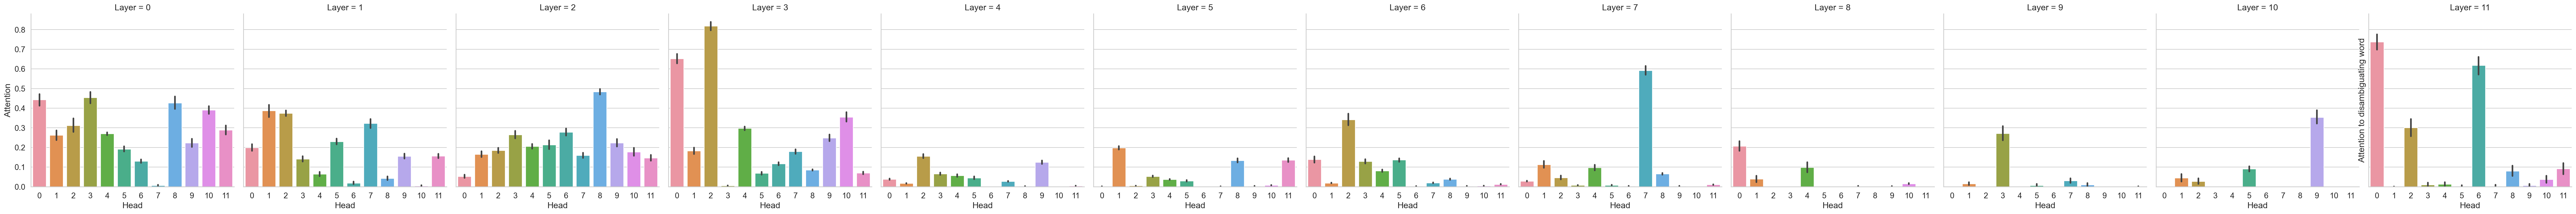

In [120]:
sns.catplot(data = df_results, x = "Head", y = "Attention", col = "Layer", kind = "bar")
plt.ylabel("Attention to disambiguating word")